# Calculating Moneyline Odds

Implementing an algorithm to determine moneyline odds for a given game in a given cup.

In [500]:
import os, sys, subprocess, json, time, math
from pprint import pprint

In [501]:
CUP = 'hellmouth'
ABBR = 'AA'
DPS = {
    'hellmouth': 49,
    'pseudo': 9,
    'toroidal': 9,
    'rainbow': 9,
    'dragon': 49,
    'star': 11,
    'klein': 11,
    'hellmouth-ii': 49,
    'star-ii': 11
}

## Regular Season Games

Start with calculating the odds of a regular season game.

To compute the odds of a regular season game, we compute regular season numbers for team A, then for team B, then compare them.

The regular season numbers have two components:

1. Past regular season performance

2. Current regular season performance

In [502]:
def fetch_season_data(which_season0, which_cup=CUP):
    seas_file = os.path.join('..', 'data', f'gollyx-{which_cup}-data', f'season{which_season0}', 'season.json')
    if not os.path.exists(seas_file):
        raise Exception(f"Error: season {which_season0} not valid: {seas_file} does not exist")
    with open(seas_file, 'r') as f:
        season0_seas = json.load(f)
    return season0_seas

In [503]:
def filter_season_data(seas_data, team_abbr=ABBR):
    team_abbr = team_abbr.upper()
    team_seas = []
    for day in seas_data:
        for game in day:
            if game['team1Abbr'] == team_abbr or game['team2Abbr'] == team_abbr:
                team_seas.append(game)
                break
    return team_seas

In [504]:
dat = filter_season_data(fetch_season_data(3), ABBR)
print(len(dat))

49


### Current Regular Season Performance

Calculate the probability of winning based only on the current season's performance, and weighting more recent days more heavily.

In [505]:
def winprob_regular_season(dat, day0, team_abbr=ABBR):
    if day0 == 0:
        return 0.5
    tri = (day0)*(day0+1)/2
    p = 0
    for i in range(day0):
        try:
            game = dat[i]
        except:
            raise Exception(f"Error accessing index {i} of dat: length {len(dat)}")
        if game['team1Abbr'] == team_abbr:
            if game['team1Score'] > game['team2Score']:
                outcome = 1
            else:
                outcome = 0
        elif game['team2Abbr'] == team_abbr:
            if game['team2Score'] > game['team1Score']:
                outcome = 1
            else:
                outcome = 0
        else:
            raise Exception(f"Error: could not find {team_abbr}")
        p += ((i+1)/tri)*outcome
    return p

Quick chart showing how the regular season probability changes as the season progresses (changes pretty wildly at the beginning, but looking better as the season goes on); consistent with the Sacramento Boot Lickers' performance in Season 4:

In [506]:
import matplotlib.pyplot as plt
import seaborn as sns

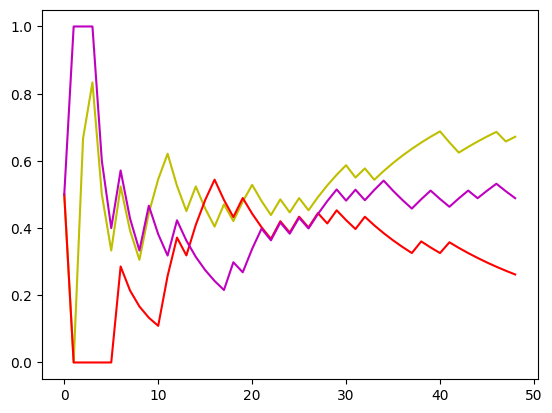

In [507]:
abbr1 = 'SAC'
dat1 = filter_season_data(fetch_season_data(3), abbr1)

abbr2 = 'AA'
dat2 = filter_season_data(fetch_season_data(3), abbr2)

abbr3 = 'LBFB'
dat3 = filter_season_data(fetch_season_data(3), abbr3)

y1 = []
y2 = []
y3 = []
for j in range(DPS['hellmouth']):
    y1.append(winprob_regular_season(dat1, j, team_abbr=abbr1))
    y2.append(winprob_regular_season(dat2, j, team_abbr=abbr2))
    y3.append(winprob_regular_season(dat3, j, team_abbr=abbr3))

plt.plot(range(49), y1, 'y')
plt.plot(range(49), y2, 'r')
plt.plot(range(49), y3, 'm')

plt.show()

### Past Regular Season Performance

We can re-use the same function, setting the day to the last day of the season to predict the odds for a given team.

These single-season predicted odds are summed together.

In [508]:
abbr = 'SAC'

winprob_regular_season(
    filter_season_data(fetch_season_data(19), abbr), 
    DPS['hellmouth'],
    team_abbr=abbr
)

0.3910204081632653

## Improve the API

Let's make the API for this functionality a little cleaner.

What we really want to be able to do is pass the following inputs:

* `cup_name`
* `team_abbr`
* `season0`
* `day0`

And get the following outputs:

* Win probability for each prior season `0..(season0-1)`
* Win probability for the current season

These outputs are obtained for Team A, then for Team B, and then combined to determine the moneyline odds.

In [509]:
def get_team_winprob_regular_season(cup_name, team_abbr, season0, day0):
    """
    Return a tuple: ([win probability for seasons 0..season0-1], win probability for season0)
    """
    team_abbr = team_abbr.upper()
    cup_name = cup_name.lower()
    prior_season_probability = []
    if season0 == 0:
        prior_season_probability = [0.5]
    else:
        for s in range(season0):
            dat = filter_season_data(fetch_season_data(s), team_abbr)
            # If len(dat)==0, this is an expansion team that didn't exist during this season
            if len(dat)>0:
                p = winprob_regular_season(dat, DPS[cup_name], team_abbr=team_abbr)
                prior_season_probability.append(p)

    dat = filter_season_data(fetch_season_data(season0), team_abbr)
    current_season_probability = winprob_regular_season(dat, day0, team_abbr=team_abbr)
    
    return (prior_season_probability, current_season_probability)

In [510]:
(prior_p, current_p) = get_team_winprob_regular_season('hellmouth', 'SAC', 19, 13)

In [511]:
print(prior_p)
print()
print(current_p)

[0.5053061224489795, 0.4979591836734694, 0.46775510204081633, 0.6448979591836735, 0.5355102040816327, 0.4342857142857144, 0.6171428571428572, 0.5346938775510205, 0.4179591836734694, 0.34122448979591835, 0.4195918367346939, 0.5404081632653062, 0.41877551020408166, 0.6277551020408164, 0.4114285714285714, 0.5444897959183674, 0.4808163265306122, 0.4359183673469388, 0.6653061224489797]

0.27472527472527475


These win probabilities represent the blocks that will be placed on either side of the scale, in order to determine the final odds.

## Computing Moneyline Odds for a Particular Regular Season Game

Let's examine the odds for one particular game in one particular season so we can see how to piece everything together.

From the SAC Analysis notebook, we found this interesting Hellmouth Cup game that took place during the Boot Lickers' Season 4 Hellmouth Cup championship run. It happened on Season 4 Day 25:

```
    bcf3c48f-3563-472b-b5e1-bf0b078b3a23 SAC  (11 - 13)  @ DET  (16 -  8)	W   	 183 -  182
```

We can determine the win probabilities for the Sacramento Boot Lickers and for the Detroit Grape Chews, and experiment with how these can be combined to give the final odds for this game.

In [512]:
season0 = 3
day0 = 24
(sac_prior_p, sac_current_p) = get_team_winprob_regular_season('hellmouth', 'SAC', season0, day0)
(det_prior_p, det_current_p) = get_team_winprob_regular_season('hellmouth', 'DET', season0, day0)

In [513]:
# Start with the simplest possible method:
# Sum up all the probabilities for each team, then divide each team's sum by the sum of both teams' sums
sacsum = sum(sac_prior_p + [sac_current_p])
detsum = sum(det_prior_p + [det_current_p])

sac = sacsum/(sacsum+detsum)
det = detsum/(sacsum+detsum)

print(sac)
print(det)

0.45927012056044314
0.540729879439557


In [514]:
# Try weighting the current season more heavily (75%) than past seasons (25%)
sacsum = 0.25*sum(sac_prior_p) + 0.75*sac_current_p
detsum = 0.25*sum(det_prior_p) + 0.75*det_current_p

sac = sacsum/(sacsum+detsum)
det = detsum/(sacsum+detsum)

print(sac)
print(det)

0.44369282308980795
0.556307176910192


In [515]:
def weighted_sum_winprob_regular_season(prior_p, current_p, prior_w=0.25, current_w=0.75):
    wsum = prior_w*sum(prior_p) + current_w*current_p
    return wsum

In [516]:
sacsum = weighted_sum_winprob_regular_season(
    *get_team_winprob_regular_season(
        'hellmouth', 'SAC', season0, day0
    )
)

detsum = weighted_sum_winprob_regular_season(
    *get_team_winprob_regular_season(
        'hellmouth', 'DET', season0, day0
    )
)

sac = sacsum/(sacsum+detsum)
det = detsum/(sacsum+detsum)

print(sac)
print(det)

0.44369282308980795
0.556307176910192


Now we can get all past regular season win probabilities, the current season win probability, and sum them up together, with whatever weights scheme we decide we want.

The probabilities (0-1) are useful for computations, but sports books usually use the "American" style odds, like `SAC (+400)` or `SAC (-110)`

We can convert the probabilities to those types of odds using a utility function:

In [517]:
def prob_to_american_odds(p, juice=0):
    """
    p = probability (0-1)
    P = percent (0-100)
    """
    P = 100*p
    if p < 0.50:
        # PLUS underdogs
        x = int((100/P)*(100-P))
        return x + juice
    else:
        # MINUS overdogs
        x = int((100*P)/(P-100))
        return x - juice

In [518]:
print(prob_to_american_odds(sac))
print(prob_to_american_odds(det))

125
-125


In reality, bets will also have "the juice" - the overhead that pays the bills for the house. Typically 10, so a 50/50 bet that would normally be +100/-100 becomes +110/-110.

In [519]:
juice = 10
print(prob_to_american_odds(sac, juice=juice))
print(prob_to_american_odds(det, juice=juice))

135
-135


Now we can assemble all of this into a function that will take a game ID, and a cup name, and will print/return odds for the two teams involved in the match.

In [520]:
def get_regular_season_odds(cup_name, game_id):
    cup_name = cup_name.lower()
    game_id = game_id.lower()
    id_key = 'id'
    the_game = None
    for season0 in range(23):
        sdat = fetch_season_data(season0, which_cup=cup_name)
        for day in sdat:
            for game in day:
                # make sure we have correct id
                if id_key not in game:
                    id_key = 'gameid'
                if game[id_key] == game_id:
                    the_game = game
                    break

    if the_game is None:
        raise Exception(f"Error: game id {game_id} not found in cup data for cup {cup_name}")
    
    team_a_abbr = the_game['team1Abbr'].upper()
    team_b_abbr = the_game['team2Abbr'].upper()
    season0 = the_game['season']
    day0 = the_game['day']
    
    a_sum = weighted_sum_winprob_regular_season(
        *get_team_winprob_regular_season(
            cup_name, team_a_abbr, season0, day0
        )
    )
    
    b_sum = weighted_sum_winprob_regular_season(
        *get_team_winprob_regular_season(
            cup_name, team_b_abbr, season0, day0
        )
    )
    
    a = a_sum/(a_sum+b_sum)
    b = b_sum/(a_sum+b_sum)

    # Make things look nice - round to nearest multiple of 5
    round_a = (prob_to_american_odds(a)//5)*5

    # Add the juice
    if round_a > 0:
        round_a += 10
    else:
        round_a -= 10

    return {
        'gameid': game_id,
        team_a_abbr: round_a,
        team_b_abbr: -1*round_a,
    }

In [521]:
# This game id is the same SAC DET match as above
get_regular_season_odds('hellmouth', 'bcf3c48f-3563-472b-b5e1-bf0b078b3a23')

{'gameid': 'bcf3c48f-3563-472b-b5e1-bf0b078b3a23', 'DET': -135, 'SAC': 135}

In [522]:
abbr = 'SAC'
dat = filter_season_data(fetch_season_data(3), abbr)
game_ids = [g['gameid'] for g in dat]

In [523]:
for game_id in game_ids[:15]:
    pprint(get_regular_season_odds('hellmouth', game_id))

{'DET': -115, 'SAC': 115, 'gameid': '5b2ff315-22e5-4546-af93-3a83557e97a3'}
{'DET': -320, 'SAC': 320, 'gameid': '113f7f16-a22f-466c-a07e-552f26de04b9'}
{'DECO': 110, 'SAC': -110, 'gameid': '72ca6eb2-35bc-4dbb-88e3-e9131ee184b8'}
{'DECO': 175, 'SAC': -175, 'gameid': '0dabcc7e-36e5-4dbc-afcd-19f2a8b457b6'}
{'DECO': -120, 'SAC': 120, 'gameid': 'b6e23135-e0b7-4a5c-bbf8-c35e9b30dfdf'}
{'DECO': -155, 'SAC': 155, 'gameid': 'e9fbc344-9d88-4282-9a67-564809623432'}
{'MILF': 130, 'SAC': -130, 'gameid': '572c06a9-8dff-413e-90cb-b9bee51f6411'}
{'MILF': -120, 'SAC': 120, 'gameid': 'ba841c66-28b7-4d35-a4bd-f073bc8a226d'}
{'SAC': -120, 'SFBS': 120, 'gameid': '44b37bd8-0485-4331-a7c1-744a11d3c2b7'}
{'SAC': -150, 'SFBS': 150, 'gameid': '7e1c2d00-d986-44ee-be49-5c1eca02ef37'}
{'SAC': -170, 'SFBS': 170, 'gameid': '894c5c54-9749-42da-bb9c-35f9f3294d01'}
{'SAC': -190, 'SFBS': 190, 'gameid': '70e366d9-ce4d-4919-bf11-5b21979c65bb'}
{'MILF': 115, 'SAC': -115, 'gameid': '06ce88bb-218e-4fa2-a1a8-65b044869b53'}
{

## Postseason Games

Now that we can get the odds in the (simpler) case of a regular season game, we can handle the case of a postseason game. This has more factors to account for.

The postseason numbers have two components:

1. Past regular season performance

2. Current regular season performance

3. Past postseason performance

4. Current postseason performance

The past postseason performance for each season weights each postseason series an increasing amount:

```
   (100 / (100+200+300))*(Division series win pct)
 + (200 / (100+200+300))*(League series win pct)
 + (300 / (100+200+300))*(Cup series win pct)
```

The current postseason performance for this season weights each postseason series the same increasing amount as above.

Factors 1 and 2 are blended together for a regular season number, independently of factors 3 and 4.

Factors 3 and 4 are blended together for a postseason number, independently of factors 1 and 2.

These regular season and postseason numbers are then blended to give a final number.

### Utility functions

First, define some utility functions to load and filter postseason data.

In [524]:
def fetch_postseason_data(which_season0, which_cup=CUP):
    post_file = os.path.join('..', 'data', f'gollyx-{which_cup}-data', f'season{which_season0}', 'postseason.json')
    if not os.path.exists(post_file):
        raise Exception(f"Error: postseason {which_season0} not valid: {post_file} does not exist")
    with open(post_file, 'r') as f:
        season0_post = json.load(f)
    return season0_post

In [525]:
def filter_postseason_data(post_data, team_abbr=ABBR, series_label=None, series_day0=None):
    """
    Filter postseason data to only include games for team_abbr.
    Up to, but NOT including, series_day0.
    """
    team_abbr = team_abbr.upper()
    team_post = {}
    for series in post_data.keys():
        if series_day0 is None or series_day0 > 0 or series != series_label:
            team_post[series] = []
        miniseason = post_data[series]
        for iday, day in enumerate(miniseason):
            if series == series_label and iday==series_day0:
                break
            found_team = False
            for game in day:
                if game['team1Abbr'] == team_abbr or game['team2Abbr'] == team_abbr:
                    team_post[series].append(game)
                    break
        if series==series_label:
            break
    return team_post

Based on the function above, the `filter_postseason_data()` will assemble a dictionary that has the same keys as the postseason data (`LDS`, `LCS`, and `HCS` or etc.), and each value will be a list of games from that series that the specified team participated in.

If a team did not make it to the final cup series, then the key's value will be an empty list.

In [526]:
def winprob_postseason(dat, team_abbr=ABBR):
    nseries = len(dat)
    tri = (nseries)*(nseries+1)/2
    p_post = 0
    for i, series in enumerate(dat):
        p_series = 0
        gameslist = dat[series]
        ngames = len(gameslist)
        if ngames > 0:
            tri_series = (ngames)*(ngames+1)/2
            for j, game in enumerate(gameslist):
                if game['team1Abbr'] == team_abbr:
                    if game['team1Score'] > game['team2Score']:
                        outcome = 1
                    else:
                        outcome = 0
                elif game['team2Abbr'] == team_abbr:
                    if game['team2Score'] > game['team1Score']:
                        outcome = 1
                    else:
                        outcome = 0
                else:
                    raise Exception(f"Error: could not find {team_abbr}")
    
                # Accumulate the win probability of this series with the outcome of this game
                p_series += ((j+1)/tri_series)*outcome

        # Accumulate the win probability of this postseason with the outcome of this series
        p_post += ((i+1)/tri)*p_series
        
    return p_post

In [527]:
abbr = 'SAC'

p = fetch_postseason_data(3)
dat = filter_postseason_data(p, abbr)
print(dat.keys())

dict_keys(['LDS', 'LCS', 'HCS'])


In [528]:
winprob_postseason(dat, abbr)

0.7365079365079366

In [529]:
abbr = 'SAC'

p = fetch_postseason_data(3)

In [530]:
print(filter_postseason_data(p, abbr, series_label='LDS', series_day0=0))

{}


In [531]:
pprint(filter_postseason_data(p, abbr, series_label='LDS', series_day0=1))

{'LDS': [{'day': 49,
          'description': 'Game 1, Hot League Division Series 1',
          'gameid': 'caa15517-00e2-4d0a-8920-0d5d1a445439',
          'generations': 2241,
          'isPostseason': True,
          'league': 'Hot League',
          'map': {'cellSize': 7,
                  'columns': 120,
                  'initialConditions1': '[{"1":[1,10,13,20,21,74,79,84]},{"2":[2,7,10,11,13,17,20,21,66,70,71,74,75,76,78,86]},{"3":[12,18,21,74,86,88]},{"4":[14,87,88]},{"5":[6,11,23,27,72,81,82,85]},{"6":[11,20,30,70,76,86,89]},{"7":[7,12,24,63,64,77,78,81]},{"8":[64]},{"9":[8,14,17,73,77,90]},{"10":[11,88]},{"11":[20,21,69,73]},{"12":[12,19,69,73,90]},{"13":[21,74,88]},{"14":[12,17,18,27,29,67]},{"15":[15,65,67,73,81,82,87]},{"16":[3,5,11,14,27,30,69,86,88,90]},{"17":[3,9,14,70,82]},{"18":[3,19,27,61,70,86]},{"19":[64,82,86]},{"20":[3,7,11,20,66,77]},{"21":[32,39,92]},{"22":[33,44,106,113]},{"23":[37,43,46,53,60,93,95,100,117,119]},{"24":[46,50,52,58,95,107,108,120]},{"25":[33,4

In [532]:
pprint(filter_postseason_data(p, abbr, series_label='LCS', series_day0=0))

{'LDS': [{'day': 49,
          'description': 'Game 1, Hot League Division Series 1',
          'gameid': 'caa15517-00e2-4d0a-8920-0d5d1a445439',
          'generations': 2241,
          'isPostseason': True,
          'league': 'Hot League',
          'map': {'cellSize': 7,
                  'columns': 120,
                  'initialConditions1': '[{"1":[1,10,13,20,21,74,79,84]},{"2":[2,7,10,11,13,17,20,21,66,70,71,74,75,76,78,86]},{"3":[12,18,21,74,86,88]},{"4":[14,87,88]},{"5":[6,11,23,27,72,81,82,85]},{"6":[11,20,30,70,76,86,89]},{"7":[7,12,24,63,64,77,78,81]},{"8":[64]},{"9":[8,14,17,73,77,90]},{"10":[11,88]},{"11":[20,21,69,73]},{"12":[12,19,69,73,90]},{"13":[21,74,88]},{"14":[12,17,18,27,29,67]},{"15":[15,65,67,73,81,82,87]},{"16":[3,5,11,14,27,30,69,86,88,90]},{"17":[3,9,14,70,82]},{"18":[3,19,27,61,70,86]},{"19":[64,82,86]},{"20":[3,7,11,20,66,77]},{"21":[32,39,92]},{"22":[33,44,106,113]},{"23":[37,43,46,53,60,93,95,100,117,119]},{"24":[46,50,52,58,95,107,108,120]},{"25":[33,4

In [533]:
print(winprob_postseason(filter_postseason_data(p, abbr, series_label='LCS', series_day0=0), abbr))

0.8


In [534]:
print("LDS:")
for dd in range(5):
    dat = filter_postseason_data(p, abbr, series_label='LDS', series_day0=dd)
    print(winprob_postseason(dat, abbr))

print("\nLCS:")
for dd in range(5):
    dat = filter_postseason_data(p, abbr, series_label='LCS', series_day0=dd)
    print(winprob_postseason(dat, abbr))

LDS:
0
0.0
0.0
0.5
0.7

LCS:
0.8
0.26666666666666666
0.711111111111111
0.8222222222222222
0.6


In [535]:
abbr = 'AA'

p = fetch_postseason_data(3)
dat = filter_postseason_data(p, abbr)
print(dat.keys())

dict_keys(['LDS', 'LCS', 'HCS'])


This number should be 0, since the AA did not make it to the postseason:

In [536]:
winprob_postseason(dat, abbr)

0.0

In [537]:
def get_team_winprob_postseason(cup_name, team_abbr, season0):
    """
    Return a tuple: ([win probability for seasons 0..season0-1], win probability for season0)
    """
    team_abbr = team_abbr.upper()
    cup_name = cup_name.lower()
    prior_postseason_probability = []
    if season0 == 0:
        prior_postseason_probability = [0.5]
    else:
        for s in range(season0):
            dat = filter_postseason_data(fetch_postseason_data(s), team_abbr)
            p = winprob_postseason(dat, team_abbr=team_abbr)
            prior_postseason_probability.append(p)

    dat = filter_postseason_data(fetch_postseason_data(season0), team_abbr)
    current_postseason_probability = winprob_postseason(dat, team_abbr=team_abbr)
    
    return (prior_postseason_probability, current_postseason_probability)


def get_team_winprob_postseason_series(cup_name, team_abbr, season0, series_label, series_day0):
    """
    Return a tuple: ([win probability for seasons 0..season0-1], win probability for season0 up to series_label and series_day0)
    """
    team_abbr = team_abbr.upper()
    cup_name = cup_name.lower()
    prior_postseason_probability = []
    if season0 == 0:
        prior_postseason_probability = [0.5]
    else:
        for s in range(season0):
            dat = filter_postseason_data(fetch_postseason_data(s), team_abbr)
            p = winprob_postseason(dat, team_abbr=team_abbr)
            prior_postseason_probability.append(p)

    dat = filter_postseason_data(fetch_postseason_data(season0), team_abbr, series_label=series_label, series_day0=series_day0)
    current_postseason_probability = winprob_postseason(dat, team_abbr)

    return (prior_postseason_probability, current_postseason_probability)

In [538]:
get_team_winprob_postseason('hellmouth', 'SAC', 3)

([0.07777777777777778, 0.0, 0.0], 0.7365079365079366)

In [539]:
get_team_winprob_postseason_series('hellmouth', 'SAC', 3, 'LDS', 0)

([0.07777777777777778, 0.0, 0.0], 0)

In [540]:
get_team_winprob_postseason_series('hellmouth', 'SAC', 3, 'LDS', 1)

([0.07777777777777778, 0.0, 0.0], 0.0)

In [541]:
get_team_winprob_postseason_series('hellmouth', 'SAC', 3, 'LDS', 2)

([0.07777777777777778, 0.0, 0.0], 0.0)

In [542]:
get_team_winprob_postseason_series('hellmouth', 'SAC', 3, 'LDS', 3)

([0.07777777777777778, 0.0, 0.0], 0.5)

In [543]:
get_team_winprob_postseason('hellmouth', 'AA', 13)

([0.0,
  0.03333333333333333,
  0.0,
  0.0,
  0.0,
  0.26666666666666666,
  0.19999999999999998,
  0.8166666666666667,
  0.016666666666666666,
  0.0,
  0.4444444444444444,
  0.0,
  0.0],
 0.05555555555555556)

In [544]:
def weighted_sum_winprob_postseason(prior_p, current_p, prior_w=0.8, current_w=0.2):
    wsum = prior_w*sum(prior_p) + current_w*current_p
    return wsum

Now we take it for a test drive. Fortunately, Season 4 Boot Lickers and Season 4 Grape Chews faced off in the postseason, in addition to the regular season, so we can see how the regular season AND postseason performances of both have affected their odds.

The Grape Chews are heavily favored, because the first few seasons they had a strong showing in LDS and LCS (despite their destined future of choking).

In [545]:
season0 = 3

sacsum = weighted_sum_winprob_postseason(
    *get_team_winprob_postseason(
        'hellmouth', 'SAC', season0,
    )
)

detsum = weighted_sum_winprob_postseason(
    *get_team_winprob_postseason(
        'hellmouth', 'DET', season0,
    )
)

sac = sacsum/(sacsum+detsum)
det = detsum/(sacsum+detsum)

print(sac)
print(det)

0.3462749213011543
0.6537250786988457


But the tables are turned by Season 21 of the Hellmouth Cup:

In [546]:
season0 = 21

sacsum = weighted_sum_winprob_postseason(
    *get_team_winprob_postseason(
        'hellmouth', 'SAC', season0,
    )
)

detsum = weighted_sum_winprob_postseason(
    *get_team_winprob_postseason(
        'hellmouth', 'DET', season0,
    )
)

sac = sacsum/(sacsum+detsum)
det = detsum/(sacsum+detsum)

print(sac)
print(det)

0.6161146089971713
0.38388539100282876


Now define the postseason version of the function that takes a game ID and computes the odds, for postseason games:

In [547]:
def get_postseason_odds(cup_name, game_id):
    cup_name = cup_name.lower()
    game_id = game_id.lower()
    id_key = 'id'
    the_game = None
    which_series = None
    which_season0 = None
    which_day0 = None
    for season0 in range(23):
        pdat = fetch_postseason_data(season0, which_cup=cup_name)
        for series in pdat:
            miniseason = pdat[series]
            for iday, day in enumerate(miniseason):
                for game in day:
                    # make sure we have correct id
                    if id_key not in game:
                        id_key = 'gameid'
                    if game[id_key] == game_id:
                        the_game = game
                        which_series = series
                        which_day0 = iday
                        break

    if the_game is None:
        raise Exception(f"Error: game id {game_id} not found in postseason cup data for cup {cup_name}")
    
    team_a_abbr = the_game['team1Abbr'].upper()
    team_b_abbr = the_game['team2Abbr'].upper()
    
    season0 = the_game['season']

    reg_a_sum = weighted_sum_winprob_regular_season(
        *get_team_winprob_regular_season(
            cup_name, team_a_abbr, season0, DPS[cup_name]
        )
    )
    
    reg_b_sum = weighted_sum_winprob_regular_season(
        *get_team_winprob_regular_season(
            cup_name, team_b_abbr, season0, DPS[cup_name]
        )
    )
    
    post_a_sum = weighted_sum_winprob_postseason(
        *get_team_winprob_postseason_series(
            cup_name, team_a_abbr, season0, which_series, which_day0
        )
    )
    
    post_b_sum = weighted_sum_winprob_postseason(
        *get_team_winprob_postseason_series(
            cup_name, team_b_abbr, season0, which_series, which_day0
        )
    )
    
    denom = reg_a_sum + reg_b_sum + 5*post_a_sum + 5*post_b_sum
    a = (reg_a_sum + 5*post_a_sum)/denom
    b = (reg_b_sum + 5*post_b_sum)/denom
    
    round_a = (prob_to_american_odds(a, juice=juice)//5)*5
    
    return {
        'description': the_game['description'],
        'gameid': game_id,
        team_a_abbr: round_a,
        team_b_abbr: -1*round_a,
    }

In [548]:
abbr = 'SAC'
dat = filter_postseason_data(fetch_postseason_data(3), abbr)
game_ids = []
for series in dat.keys():
    game_ids += [g['gameid'] for g in dat[series]]

In [549]:
for game_id in game_ids:
    o = get_postseason_odds('hellmouth', game_id)
    #pprint(o)

In [550]:
abbr = 'SAC'
dat = filter_postseason_data(fetch_postseason_data(20), abbr)
game_ids = []
for series in dat.keys():
    game_ids += [g['gameid'] for g in dat[series]]

In [551]:
for game_id in game_ids:
    pprint(get_postseason_odds('hellmouth', game_id))

{'DET': 135,
 'SAC': -135,
 'description': 'Game 1, Hot League Division Series 2',
 'gameid': '74ddb200-822a-460a-a398-79cb0218149e'}
{'DET': 145,
 'SAC': -145,
 'description': 'Game 2, Hot League Division Series 2',
 'gameid': '0c1fc60c-2ff6-4edd-82c4-370c4d29eb0e'}
{'DET': 150,
 'SAC': -150,
 'description': 'Game 3, Hot League Division Series 2',
 'gameid': '44b88b11-4943-46fa-b5df-96e9e29a7f4f'}
{'DET': 140,
 'SAC': -140,
 'description': 'Game 4, Hot League Division Series 2',
 'gameid': '60d3fcc9-ef98-474f-94e8-7567c884f592'}
{'DET': 130,
 'SAC': -130,
 'description': 'Game 5, Hot League Division Series 2',
 'gameid': '554b21fb-daf5-42f7-af84-2b62015f57f8'}
{'MILF': -150,
 'SAC': 150,
 'description': 'Game 1, Hot League Championship Series',
 'gameid': 'ef2c6d5b-fda0-44b5-aea8-d8b63d09191c'}
{'MILF': -140,
 'SAC': 140,
 'description': 'Game 2, Hot League Championship Series',
 'gameid': '6e7ae968-10f6-4280-bde3-f07b6b303be1'}
{'MILF': -145,
 'SAC': 145,
 'description': 'Game 3, Hot

In [552]:
abbr = 'ABQ'
dat = filter_postseason_data(fetch_postseason_data(22, which_cup='toroidal'), abbr)
game_ids = []
for series in dat.keys():
    game_ids += [g['gameid'] for g in dat[series]]

In [553]:
for game_id in game_ids:
    pprint(get_postseason_odds('toroidal', game_id))

{'ABQ': -145,
 'SGE': 145,
 'description': 'Game 1, Hot League Division Series 2',
 'gameid': '67088564-7e50-41fa-acfc-6ab16959ce68'}
{'ABQ': -145,
 'SGE': 145,
 'description': 'Game 2, Hot League Division Series 2',
 'gameid': 'a782653d-5424-4018-95f6-267494bd5bbc'}
{'ABQ': -150,
 'SGE': 150,
 'description': 'Game 3, Hot League Division Series 2',
 'gameid': '6e8ddd0e-fcb2-4e6b-b18c-2c822899fce0'}
{'ABQ': -180,
 'SGE': 180,
 'description': 'Game 4, Hot League Division Series 2',
 'gameid': '221c2723-85d5-4963-afef-734750f2e0f7'}
{'ABQ': -185,
 'SGE': 185,
 'description': 'Game 5, Hot League Division Series 2',
 'gameid': '16ec7c90-9ce5-4110-be5a-18a6210b9a9f'}
{'ABQ': 330,
 'DET': -330,
 'description': 'Game 1, Hot League Championship Series',
 'gameid': 'f40fe9e2-9f01-45f8-b66b-5957a0cf63cb'}
{'ABQ': 395,
 'DET': -395,
 'description': 'Game 2, Hot League Championship Series',
 'gameid': '1b523ede-414f-4c14-b084-f4e2b336f212'}
{'ABQ': 390,
 'DET': -390,
 'description': 'Game 3, Hot Le

In [557]:
get_team_winprob_postseason('toroidal', 'ABQ', 22)

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.049999999999999996,
  0.0,
  0.18333333333333335,
  0.05555555555555555,
  0.0],
 0.23333333333333334)

In [558]:
get_team_winprob_postseason('toroidal', 'TB', 22)

([0.28888888888888886,
  0.016666666666666666,
  0.07777777777777778,
  0.0,
  0.049999999999999996,
  0.0,
  0.07777777777777778,
  0.0,
  0.5666666666666667,
  0.5626984126984127,
  0.0,
  0.0,
  0.0,
  0.0,
  0.05555555555555556,
  0.0,
  0.0,
  0.0,
  0.0,
  0.016666666666666666,
  0.0,
  0.0],
 0.18888888888888888)